# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Understand batching for a recurrent neural network, and develop custom Dataset and DataLoaders with collate_fn to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link https://drive.google.com/file/d/1Tr0lCqfFkmYzGEJxw_wdxKHNbNGyihJ4/view?usp=sharing

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#label for spam = spam, non-span = ham
for line in open('SMSSpamCollection'):
  if line[0] == 'h':
    print(line)
    break

for line in open('SMSSpamCollection'):
  if line[0] == "s":
    print(line)
    break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam = 0
ham = 0
for line in open('SMSSpamCollection'):
  if line[0] == 's':
    spam += 1
  else:
    ham += 1
print("Spam:")
print(spam)
print("Ham:")
print(ham)

Spam:
747
Ham:
4827


### Part (c) [4 pt]

load and parse the data into two lists: sequences and labels. Create character-level stoi and itos dictionaries. Reserve the index 0 for padding. Convert the sequences to list of character ids using stoi dictionary and convert the labels to a list of 0s and 1s by assinging class "ham" to 0 and class "spam" to 1.

In [ ]:
sequences = []
labels = []

#initialize with pad=0
stoi = {'<pad>': 0}
itos = {0: '<pad>'}
idx = 1

for line in open('SMSSpamCollection', 'r', encoding='utf-8'):
    line = line.strip()
    if not line:
        continue

    # split label vs text
    label, text = line.split('\t', 1)
    labels.append(1 if label == 'spam' else 0)

    seq_ids = []
    for ch in text:
        if ch not in stoi:
            stoi[ch] = idx
            itos[idx] = ch
            idx += 1
        seq_ids.append(stoi[ch])

    sequences.append(seq_ids)

### Part (d) [4 pt]

Use train_test_split function from sklearn (https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.train_test_split.html) to split the data indices into `train`, `valid`, and `test`. Use a 60-20-20 split.

You saw in part (b) that there are many more non-spam messages than spam messages. This **imbalance** in our training data will be problematic for training. We can fix this disparity by duplicating spam messages in the training set, so that the training set is roughly balanced.

In [ ]:
from sklearn.model_selection import train_test_split

indices = list(range(len(sequences)))

train_index, temp_index = train_test_split(indices, test_size=0.4, random_state=42, stratify=labels)

val_index, test_index = train_test_split(temp_index, test_size=0.5, random_state=42,
                                        stratify=[labels[i] for i in temp_index])

#create train, validation, and test sets
train_x = [sequences[idx] for idx in train_index]
train_y = [labels[idx] for idx in train_index]
val_x = [sequences[idx] for idx in val_index]
val_y = [labels[idx] for idx in val_index]
test_x = [sequences[idx] for idx in test_index]
test_y = [labels[idx] for idx in test_index]

print(f"Training set size: {len(train_x)}")
print(f"Validation set size: {len(val_x)}")
print(f"Test set size: {len(test_x)}")

train_ham = sum(1 for label in train_y if label == 0)
train_spam_count = sum(1 for label in train_y if label == 1)
print(f"Train set before balancing: Ham={train_ham}, Spam={train_spam_count}")

#balance the train classes
train_spam = []
for idx, item in enumerate(train_x):
    if train_y[idx] == 1:
        train_spam.append(item)

#duplicate spam message
train_x = train_x + train_spam * 6
train_y = train_y + [1] * (len(train_spam) * 6)

train_ham_after = sum(1 for label in train_y if label == 0)
train_spam_after = sum(1 for label in train_y if label == 1)
print(f"Train set after balancing: Ham={train_ham_after}, Spam={train_spam_after}")
print(f"Final training set size: {len(train_x)}")

Training set size: 3344
Validation set size: 1115
Test set size: 1115
Train set before balancing: Ham=2896, Spam=448
Train set after balancing: Ham=2896, Spam=3136
Final training set size: 6032


### Part (e) [4 pt]

Since each sequence has a different length, we cannot use the default DataLoader. We need to change the DataLoader such that it can pad differnt sequence sizes within the batch. To do this, we need to introduce a **collate_fn** to the DataLoader such that it uses **pad_sequence** function (https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html) to pad the sequences within the batch to the same size.

We also need a custom Dataset class to return a pair of sequence and label for each example. Complete the code below to address these.

Hint:
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
- https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

In [ ]:
class MyDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sequence, label

def collate_sequences(batch):
    sequences = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)

    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)

    return padded_sequences, labels

#DataLoaders
train_loader = DataLoader(dataset=MyDataset(train_x, train_y), batch_size=32, shuffle=True, collate_fn=collate_sequences)
val_loader = DataLoader(dataset=MyDataset(val_x, val_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)
test_loader = DataLoader(dataset=MyDataset(test_x, test_y), batch_size=32, shuffle=False, collate_fn=collate_sequences)

### Part (f) [1 pt]

Take a look at 10 batches in `train_loader`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?


In [ ]:
#counter - only up to 10
batch_count = 0

for batch in train_loader:
    if batch_count >= 10:
        break

    sequences, _ = batch
    batch_size = sequences.size(0)
    max_length = sequences.size(1)

    pad_count = torch.sum(sequences == 0).item()

    print(f"Batch {batch_count + 1}:")
    print(f"  Maximum sequence length: {max_length}")
    print(f"  Number of padding tokens: {pad_count}")

    batch_count += 1

Batch 1:
  Maximum sequence length: 167
  Number of padding tokens: 2253
Batch 2:
  Maximum sequence length: 160
  Number of padding tokens: 2241
Batch 3:
  Maximum sequence length: 247
  Number of padding tokens: 4622
Batch 4:
  Maximum sequence length: 160
  Number of padding tokens: 2544
Batch 5:
  Maximum sequence length: 161
  Number of padding tokens: 2171
Batch 6:
  Maximum sequence length: 180
  Number of padding tokens: 2343
Batch 7:
  Maximum sequence length: 183
  Number of padding tokens: 1994
Batch 8:
  Maximum sequence length: 281
  Number of padding tokens: 5611
Batch 9:
  Maximum sequence length: 160
  Number of padding tokens: 1857
Batch 10:
  Maximum sequence length: 160
  Number of padding tokens: 1580


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class SpamRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=2, dropout=0.5):
        super(SpamRNN, self).__init__()

        # one-hot embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        with torch.no_grad():
            self.embedding.weight.copy_(torch.eye(vocab_size))
            self.embedding.weight.requires_grad = False

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)

        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):

        embedded = self.embedding(x)

        out, (hidden, cell) = self.lstm(embedded)

        max_pool = torch.max(out, dim=1)[0]
        avg_pool = torch.mean(out, dim=1)
        combined = torch.cat([max_pool, avg_pool], dim=1)

        out = self.dropout(combined)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)

        return out

vocab_size = len(stoi)
embedding_dim = vocab_size
hidden_dim = 128
output_dim = 2

model = SpamRNN(vocab_size, embedding_dim, hidden_dim, output_dim)

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data:
            sequences, labels = batch
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    print_every = 1  #print every epoch

    #training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            sequences, labels = batch
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()

            #forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)

            #backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        history['train_losses'].append(avg_train_loss)
        train_acc = get_accuracy(model, train_loader)
        history['train_accuracies'].append(train_acc)

        #validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                sequences, labels = batch
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history['val_losses'].append(avg_val_loss)
        val_acc = get_accuracy(model, val_loader)
        history['val_accuracies'].append(val_acc)

        if (epoch + 1) % print_every == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return history

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracies'], label='Train Accuracy')
    plt.plot(history['val_accuracies'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch [1/10]
Train Loss: 0.4577, Train Acc: 0.9428
Val Loss: 0.1378, Val Acc: 0.9507
Epoch [2/10]
Train Loss: 0.1918, Train Acc: 0.9282
Val Loss: 0.1013, Val Acc: 0.9740
Epoch [3/10]
Train Loss: 0.1608, Train Acc: 0.9639
Val Loss: 0.0809, Val Acc: 0.9767
Epoch [4/10]
Train Loss: 0.1140, Train Acc: 0.9637
Val Loss: 0.1358, Val Acc: 0.9543
Epoch [5/10]
Train Loss: 0.1049, Train Acc: 0.9736
Val Loss: 0.0854, Val Acc: 0.9758
Epoch [6/10]
Train Loss: 0.0950, Train Acc: 0.9733
Val Loss: 0.0828, Val Acc: 0.9767
Epoch [7/10]
Train Loss: 0.0865, Train Acc: 0.9798
Val Loss: 0.0840, Val Acc: 0.9749
Epoch [8/10]
Train Loss: 0.0777, Train Acc: 0.9796
Val Loss: 0.0634, Val Acc: 0.9830
Epoch [9/10]
Train Loss: 0.0588, Train Acc: 0.9821
Val Loss: 0.1105, Val Acc: 0.9632
Epoch [10/10]
Train Loss: 0.0515, Train Acc: 0.9833
Val Loss: 0.0666, Val Acc: 0.9821


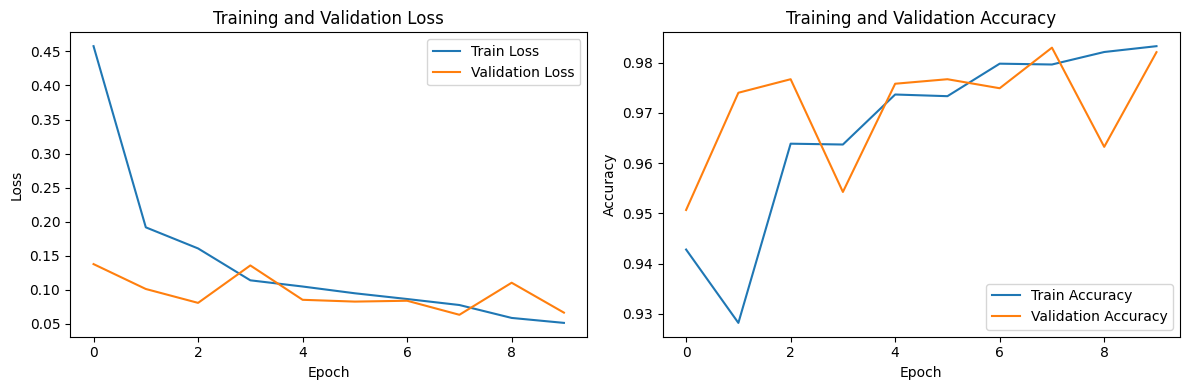

In [ ]:
#baseline model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

baseline_config = {
    'hidden_dim': 128,
    'num_layers': 2,
    'dropout': 0.5,
    'num_epochs': 10,
    'learning_rate': 0.001
}

baseline_model = SpamRNN(vocab_size=len(stoi),
                        embedding_dim=len(stoi),
                        hidden_dim=baseline_config['hidden_dim'],
                        output_dim=2,
                        num_layers=baseline_config['num_layers'],
                        dropout=baseline_config['dropout']).to(device)

baseline_history = train_model(baseline_model,
                              train_loader,
                              val_loader,
                              baseline_config['num_epochs'],
                              baseline_config['learning_rate'],
                              device)

#plot
plot_training_history(baseline_history)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

**Answer**

### Tune 1:  
From the baseline model there seems to be a large gap between the training and validation accuracy and the validation loss plateaus very early on. Therefore, this model seems to be memorizing training data (overfitting) due to the high capacity. I will try to improve this by changing the parameters by increasing the dropout to 0.7 to increase regularization, reduce the hidden dimensions to 64 to reduce model capacity, and increase the number of epochs to 15.  

*tune1_config = {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.7,    
'num_epochs': 15, 'learning_rate': 0.001
}*


### Tune 2:
The results of the previous tune imporved greatly. The loss curves decrease together now and more earlier, and the space between the accuracy curves are closer together. However it seems to straighten out early on in the epochs which might mean that the model learns to generalize the patterns too quickly. To fix this I will try to increase the hidden layers a little bit for more capacity, reduce the regularization, increase training time, and rate.

*tune4_config = {'hidden_dim': 96, 'num_layers': 2, 'dropout': 0.5, 'num_epochs': 20,'learning_rate': 0.002}*

### Tune 3:
This resulted in the validation loss and accuracy charts to be very straight, did not follow the training curves. To fix this I want to try and decreasing the learning rate, increase the hidden dimension, reduce the dropout a little more, and add more layers for complexity.

*tune1_config = {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.3 'num_epochs': 20,'learning_rate': 0.0005
}*

### Tune 4:
This result had early training instability (loss spikes/accuracy dips around epochs 2-3). To try and fix this further I tried these new parameters:

*tune1_config = {'hidden_dim': 112, 'num_layers': 2, 'dropout': 0.4, 'num_epochs': 25, 'learning_rate': 0.0008,'batch_size': 48}*
This didn't really improve the results, it was more scattered and had a wider gap between the curves.

In the end, I think that tune 3 produced the best results, even though there were spikes during the early epochs.

In [ ]:
tune5_config = {
    'hidden_dim': 128,       # Increased from 96 (more representational power)
    'num_layers': 2,         # Kept same
    'dropout': 0.3,          # Reduced from 0.5 (less regularization)
    'num_epochs': 15,        # Extended training
    'learning_rate': 0.0005,  # Slightly reduced from 0.002
    'batch_size': 64              # Increased from 32
}

# Update DataLoader with new batch_size
train_loader = DataLoader(MyDataset(train_x, train_y),
                         batch_size=tune5_config['batch_size'],
                         shuffle=True,
                         collate_fn=collate_sequences)

tune5_model = SpamRNN(
    vocab_size=len(stoi),
    embedding_dim=len(stoi),
    hidden_dim=tune5_config['hidden_dim'],
    output_dim=2,
    num_layers=tune5_config['num_layers'],
    dropout=tune5_config['dropout']
).to(device)

tune5_history = train_model(
    tune5_model,
    train_loader,
    val_loader,
    tune5_config['num_epochs'],
    tune5_config['learning_rate'],
    device
)
plot_training_history(tune5_history)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
valid_spam_indices = [i for i, label in enumerate(val_y) if label == 1]
valid_nospam_indices = [i for i, label in enumerate(val_y) if label == 0]

valid_spam_x = [val_x[i] for i in valid_spam_indices]
valid_spam_y = [val_y[i] for i in valid_spam_indices]
valid_nospam_x = [val_x[i] for i in valid_nospam_indices]
valid_nospam_y = [val_y[i] for i in valid_nospam_indices]

valid_spam_loader = DataLoader(dataset=MyDataset(valid_spam_x, valid_spam_y),
                              batch_size=32,
                              shuffle=False,
                              collate_fn=collate_sequences)
valid_nospam_loader = DataLoader(dataset=MyDataset(valid_nospam_x, valid_nospam_y),
                                batch_size=32,
                                shuffle=False,
                                collate_fn=collate_sequences)

fn = 1 - get_accuracy(tune5_history, valid_spam_loader)
fp = 1 - get_accuracy(tune5_history, valid_nospam_loader)

print("False Negative Rate: ", fn*100, "%")
print("False Positive Rate: ", fp*100, "%")

NameError: name 'tune1_model' is not defined

### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?


**Answer**


A false positive is when a real message would be marked as spam. Bad because you might miss an important message and sent directly to spam.

A false negative is when a spam message would be marked as real. Bad because spam messages will show up in your inbox.


## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
final_test_accuracy = get_accuracy(tune5_history, test_loader)
print("The final test accuracy is:", final_test_accuracy*100, "%")

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
test_spam_indices = [i for i, label in enumerate(test_y) if label == 1]
test_nospam_indices = [i for i, label in enumerate(test_y) if label == 0]

test_spam_x = [test_x[i] for i in test_spam_indices]
test_spam_y = [test_y[i] for i in test_spam_indices]
test_nospam_x = [test_x[i] for i in test_nospam_indices]
test_nospam_y = [test_y[i] for i in test_nospam_indices]

test_spam_loader = DataLoader(dataset=MyDataset(test_spam_x, test_spam_y),
                              batch_size=32,
                              shuffle=False,
                              collate_fn=collate_sequences)
test_nospam_loader = DataLoader(dataset=MyDataset(test_nospam_x, test_nospam_y),
                                batch_size=32,
                                shuffle=False,
                                collate_fn=collate_sequences)

test_fn = 1 - get_accuracy(tune5_history, test_spam_loader)
test_fp = 1 - get_accuracy(tune5_history, test_nospam_loader)

print("Test False Negative Rate: ", test_fn*100, "%")
print("Test False Positive Rate: ", test_fp*100, "%")

### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"

msg_sequence = [stoi.get(char, 0) for char in msg]

msg_tensor = torch.tensor(msg_sequence, dtype=torch.long).unsqueeze(0).to(device)

baseline_model.eval()

with torch.no_grad():
    output = baseline_model(msg_tensor)
    probabilities = torch.softmax(output, dim=1)
    spam_probability = probabilities[0, 1].item()

print(f"Probability that the message '{msg}' is spam: {spam_probability * 100:.2f}%")

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

**Answer**

I think that detecting spam can be complex because you don't know what people consider as spam, or many spam emails have gotten better at sounding not like spam. For example, emails regarding sales at stores, some might prefer seeing that while others may not.

I think the Bag-of-Words approach is a good idea for a baseline for spam detection because it catches important signal words while being  simple and fast. To implement this you can create a vocabulary of frequently used words from your data, then convert each email into a fixed-length vector where each position represents the count or presence of a specific word from your vocabulary. You would then train a simple classifier, where the model learns which words are most seen in spam versus actual important emails. This ignores word order and grammar but captures the key discriminative vocabulary patterns that distinguish spam (words like "free," "winner," "urgent," "congratulations") from normal emails.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab5_Spam_Detection_Final.ipynb